In [1]:
from constants import FLUXES_FOLDER, \
                      SLM_FOLDER

from data_utils import process_amp_phase_data, \
                       add_row_padding

from plot_utils import plot_map, \
                       plot_model_history, \
                       plot_autoencoder, \
                       plot_enc_conv_amp_phase_prediction


from modeling_utils import create_autoencoder_for_flux, \
                           create_convolutional_architecture_with_encoder_for_amplitude_phase_reconstruction, \
                           compile_model, \
                           train_model, \
                           store_model

from configurations import AutoEncoderConfiguration, \
                           EncoderConvolutionalConfiguration

2023-12-04 11:59:03.554833: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 11:59:04.321867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
fluxes_filename = "all_fluxes.npy"
amplitudes_filename = "complexsine_pupamp.npy"
phases_filename = "complexsine_pupphase.npy"

fluxes_path = f"{FLUXES_FOLDER}/{fluxes_filename}"
amplitudes_path = f"{SLM_FOLDER}/{amplitudes_filename}"
phases_path = f"{SLM_FOLDER}/{phases_filename}"

In [3]:
train_fluxes_array, val_fluxes_array, train_amp_phase_array, val_amp_phase_array, scalers = \
    process_amp_phase_data(
        fluxes_path, 
        amplitudes_path,
        phases_path,
        n_points=10000,
        trim_amplitude=False,
        trim_phase=False,
        normalize_flux=True,
        normalize_amplitude=True,
        shuffle=False,
        flatten_fluxes=False,
        split=True,
        val_ratio=0.1,
        flux_top_padding=1,
        amp_phase_top_padding=8,
        amp_phase_bottom_padding=8
    )

In [4]:
train_amp_phase_array.shape

(9000, 2, 112, 96)

In [5]:
plot_map(train_amp_phase_array[0][0])

In [6]:
model_configuration = AutoEncoderConfiguration(train_fluxes_array)
print(model_configuration.get_description())


	=== FluxAutoencoder ===
	*ARCHITECTURE HYPERPARAMETERS:
		-Autoencoder
		-Input shape: (56, 24)
		-Convolutional Layers: [256, 128, 16, 4] (Inverse in the decoder)
		-Convolutonal Kernels: [(3, 3), (3, 3), (3, 3), (3, 3)] (Inverse in the decoder)
		-Convolutional Activation: relu
		-Output Layer Activation: linear
	
	*COMPILATION HYPERPARAMETERS:
		-Optimizer: ADAM lr=0.001, beta_1=0.9, beta_2=0.999
		-Loss Function: MSE
		-Metric: MSE
	
	* TRAINING HYPERPARAMETERS:
		-Epochs: 1
		-Batch size: 16
		-Callbacks:
			-ReduceLROnPlateau: MSE 8 x0.1
			-Early Stop: MSE 15
	


2023-12-04 11:59:13.903667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 11:59:13.942229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 11:59:13.942529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
model = create_autoencoder_for_flux(
    *model_configuration.unpack_architecture_hyperparameters()
)


Model: "FluxAutoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 24, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 24, 256)       590080    
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 12, 256)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 12, 128)       295040    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 12, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 6, 128)        0         
 g2D)                                              

In [8]:
compile_model(
    model,
    *model_configuration.unpack_compilation_hyperparameters()
)

In [9]:
history = train_model(
    model,
    train_fluxes_array,
    train_fluxes_array,
    val_fluxes_array,
    val_fluxes_array,
    *model_configuration.unpack_training_hyperparameters()
)

2023-12-04 11:59:17.542833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-04 11:59:18.329182: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-04 11:59:18.329232: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-04 11:59:19.151439: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f38dce58000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-04 11:59:19.151479: I tensorflow/compiler/xla/service/service.cc:176]   Str

561/563 [============================>.] - ETA: 0s - loss: 0.2482 - mean_squared_error: 0.2482

2023-12-04 11:59:43.365150: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


563/563 [==============================] - 31s 39ms/step - loss: 0.2478 - mean_squared_error: 0.2478 - val_loss: 0.1357 - val_mean_squared_error: 0.1357 - lr: 1.0000e-04


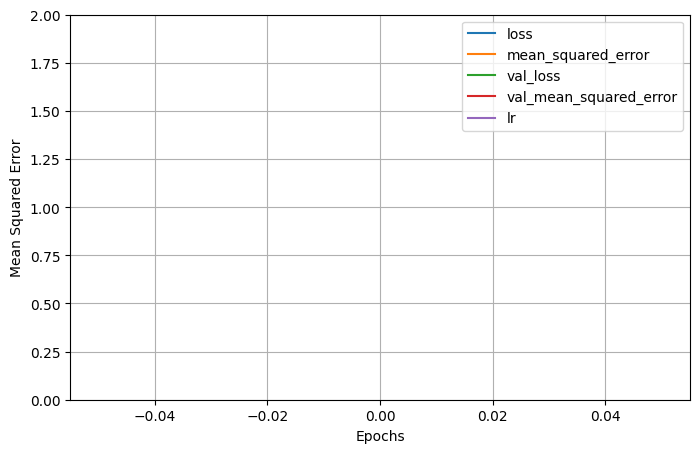

In [10]:
plot_model_history(history)

In [11]:
plot_autoencoder(model, val_fluxes_array[757])

1/1 [==============================] - 0s 445ms/step


In [12]:
plot_autoencoder(model, val_fluxes_array[758])

1/1 [==============================] - 0s 16ms/step


In [13]:
store_model(model,
            model.name,
            model_configuration.get_description())

In [14]:
model_configuration = EncoderConvolutionalConfiguration()

In [15]:
enc_conv_model = create_convolutional_architecture_with_encoder_for_amplitude_phase_reconstruction(
    model,
    *model_configuration.unpack_architecture_hyperparameters())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 56, 24, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 56, 24, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 24, 256)       590080    
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 12, 256)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 12, 128)       295040    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 12, 128)       147584    
                                                           

In [16]:
compile_model(
    enc_conv_model,
    *model_configuration.unpack_compilation_hyperparameters()
)

In [17]:
import numpy as np
train_amp_phase_array = np.swapaxes(train_amp_phase_array, 1, 3)
train_amp_phase_array = np.swapaxes(train_amp_phase_array, 1, 2)
val_amp_phase_array = np.swapaxes(val_amp_phase_array, 1, 3)
val_amp_phase_array = np.swapaxes(val_amp_phase_array, 1, 2)

In [18]:

history = train_model(
    enc_conv_model,
    train_fluxes_array,
    train_amp_phase_array,
    val_fluxes_array,
    val_amp_phase_array,
    *model_configuration.unpack_training_hyperparameters()
)

2023-12-04 11:59:48.981445: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 774144000 exceeds 10% of free system memory.
2023-12-04 11:59:49.645255: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 774144000 exceeds 10% of free system memory.


Epoch 1/10
563/563 [==============================] - 25s 35ms/step - loss: 0.5893 - mean_squared_error: 0.5893 - val_loss: 0.5913 - val_mean_squared_error: 0.5913 - lr: 1.0000e-04
Epoch 2/10
563/563 [==============================] - 18s 32ms/step - loss: 0.5722 - mean_squared_error: 0.5722 - val_loss: 0.5890 - val_mean_squared_error: 0.5890 - lr: 1.0000e-04
Epoch 3/10
563/563 [==============================] - 18s 31ms/step - loss: 0.5707 - mean_squared_error: 0.5707 - val_loss: 0.5883 - val_mean_squared_error: 0.5883 - lr: 1.0000e-04
Epoch 4/10
563/563 [==============================] - 18s 31ms/step - loss: 0.5700 - mean_squared_error: 0.5700 - val_loss: 0.5885 - val_mean_squared_error: 0.5885 - lr: 1.0000e-04
Epoch 5/10
563/563 [==============================] - 18s 31ms/step - loss: 0.5695 - mean_squared_error: 0.5695 - val_loss: 0.5877 - val_mean_squared_error: 0.5877 - lr: 1.0000e-04
Epoch 6/10
563/563 [==============================] - 18s 32ms/step - loss: 0.5690 - mean_squar

In [19]:
train_amp_phase_array = np.swapaxes(train_amp_phase_array, 2, 1)
train_amp_phase_array = np.swapaxes(train_amp_phase_array, 3, 1)
val_amp_phase_array = np.swapaxes(val_amp_phase_array, 2, 1)
val_amp_phase_array = np.swapaxes(val_amp_phase_array, 3, 1)

In [20]:
print(train_amp_phase_array.shape)
plot_map(train_amp_phase_array[0][0])

(9000, 2, 112, 96)


In [21]:
plot_enc_conv_amp_phase_prediction(enc_conv_model,
                                   train_fluxes_array[0], 
                                   train_amp_phase_array[0][0],
                                   train_amp_phase_array[0][1])

1/1 [==============================] - 0s 376ms/step
